<a href="https://colab.research.google.com/github/mobarakol/PitVQA/blob/main/PitVQANet_pit24_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Download code
!git clone https://github.com/HRL-Mike/PitVQA.git

#Download Dataset
!mkdir /content/PitVQA/datasets
%cd /content/PitVQA/datasets
!gdown 13KYAYTF5RzrxYQC8BQCwN2lor4IyOCOk

# Unzipping the VQA EndoVis18 Dataset
!unzip -q PitVQA-24-val.zip
%cd /content/PitVQA

Cloning into 'PitVQA'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 126 (delta 41), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (126/126), 139.64 KiB | 4.65 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/PitVQA/datasets
Downloading...
From (original): https://drive.google.com/uc?id=13KYAYTF5RzrxYQC8BQCwN2lor4IyOCOk
From (redirected): https://drive.google.com/uc?id=13KYAYTF5RzrxYQC8BQCwN2lor4IyOCOk&confirm=t&uuid=98aef054-b717-4c93-a4a9-38942be6b0ff
To: /content/PitVQA/datasets/PitVQA-24-val.zip
100% 1.92G/1.92G [00:39<00:00, 49.0MB/s]
/content/PitVQA


In [ ]:
# download weights
!gdown 1Fji8gOW-kh5BMsvL7yKY9-F-AbHqcDzF
# https://drive.google.com/file/d/1Fji8gOW-kh5BMsvL7yKY9-F-AbHqcDzF/view?usp=drive_link

Downloading...
From (original): https://drive.google.com/uc?id=1Fji8gOW-kh5BMsvL7yKY9-F-AbHqcDzF
From (redirected): https://drive.google.com/uc?id=1Fji8gOW-kh5BMsvL7yKY9-F-AbHqcDzF&confirm=t&uuid=90dd3432-27ec-4a62-804f-f1a47f1df295
To: /content/PitVQA/pitvqa_pit24_weights_3.pth.tar
100% 4.07G/4.07G [01:24<00:00, 47.9MB/s]


In [ ]:
!pip install -q timm==0.9.12 fairscale==0.4.13 scikit-learn==1.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 30.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 59.3 MB/s eta 0:00:00


### Define functions

In [ ]:
import torch
from dataloader import Pit24VQAClassification
from utils import calc_acc, calc_precision_recall_fscore

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm

import os
import sys
import random
import numpy as np
import warnings
warnings.filterwarnings("ignore")


def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


def validate(val_loader, model, criterion, device):
    model.eval()
    total_loss = 0.0
    label_true = None
    label_pred = None
    label_score = None

    with torch.no_grad():
        for i, (file_name, images, questions, labels) in enumerate(tqdm(val_loader),0):
            # label
            labels = labels.to(device)

            # model forward pass
            outputs = model(image=images.to(device), question=questions)

            # loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            scores, predicted = torch.max(F.softmax(outputs, dim=1).data, 1)
            label_true = labels.data.cpu() if label_true is None else torch.cat((label_true, labels.data.cpu()), 0)
            label_pred = predicted.data.cpu() if label_pred is None else torch.cat((label_pred, predicted.data.cpu()), 0)
            label_score = scores.data.cpu() if label_score is None else torch.cat((label_score, scores.data.cpu()), 0)

    acc = calc_acc(label_true, label_pred)
    precision, recall, f_score = calc_precision_recall_fscore(label_true, label_pred)
    print(f'\ntest acc: {acc} | test precision: {precision} | test recall: {recall} | test F1: {f_score}')
    return acc, precision, recall, f_score

### Evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
seed_everything(42)

# preapre model
model_path = 'pitvqa_pit24_weights_3.pth.tar'
checkpoint = torch.load(model_path, map_location='cpu')
model = checkpoint['model']
model.to(device)
criterion = nn.CrossEntropyLoss().to(device)

# prepare validation set
val_seq = ['02', '06', '12', '13', '24']
folder_head = '/content/PitVQA/datasets/PitVQA-24-val/QA/video_'
folder_tail = '/*.txt'
val_dataset = Pit24VQAClassification(val_seq, folder_head, folder_tail)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

test_acc, test_precision, test_recall, test_f_score = validate(val_loader=val_dataloader, model=model,
                                  criterion=criterion, device=device)

Total files: 24767 | Total question: 203868


100%|██████████| 3186/3186 [1:01:51<00:00,  1.17s/it]


test acc: 0.7603939804187023 | test precision: 0.6652634815093893 | test recall: 0.5747971198100366 | test F1: 0.5835304342958242


### Balanced Accuracy

In [ ]:
from sklearn.metrics import balanced_accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
seed_everything(42)

# preapre model
model_path = 'pitvqa_pit24_weights_3.pth.tar'
checkpoint = torch.load(model_path, map_location='cpu')
model = checkpoint['model']
model.to(device)

# prepare validation set
val_seq = ['02', '06', '12', '13', '24']
folder_head = '/content/PitVQA/datasets/PitVQA-24-val/QA/video_'
folder_tail = '/*.txt'
val_dataset = Pit24VQAClassification(val_seq, folder_head, folder_tail)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# evaluation
label_true = None
label_pred = None
model.eval()
with torch.no_grad():
    for i, (file_name, images, questions, labels) in enumerate(tqdm(val_dataloader),0):
        labels = labels.to(device)
        outputs = model(image=images.to(device), question=questions)

        scores, predicted = torch.max(F.softmax(outputs, dim=1).data, 1)
        if label_true is None:
            label_true = labels.data.cpu()
        else:
            label_true = torch.cat((label_true, labels.data.cpu()), 0)
        if label_pred is None:
            label_pred = predicted.data.cpu()
        else:
            label_pred = torch.cat((label_pred, predicted.data.cpu()), 0)

    score = balanced_accuracy_score(label_true.numpy(), label_pred.numpy())
    print(f'balanced_accuracy_score: {score}')

Total files: 24767 | Total question: 203868


100%|██████████| 3186/3186 [1:02:13<00:00,  1.17s/it]

balanced_accuracy_score: 0.567337420157581


### Demo

Downloading...
From: https://drive.google.com/uc?id=1qq2pVjZ-CZVVKP7gElERZVlgo9AjpmQq
To: /content/PitVQA/03828.png
100% 546k/546k [00:00<00:00, 114MB/s]


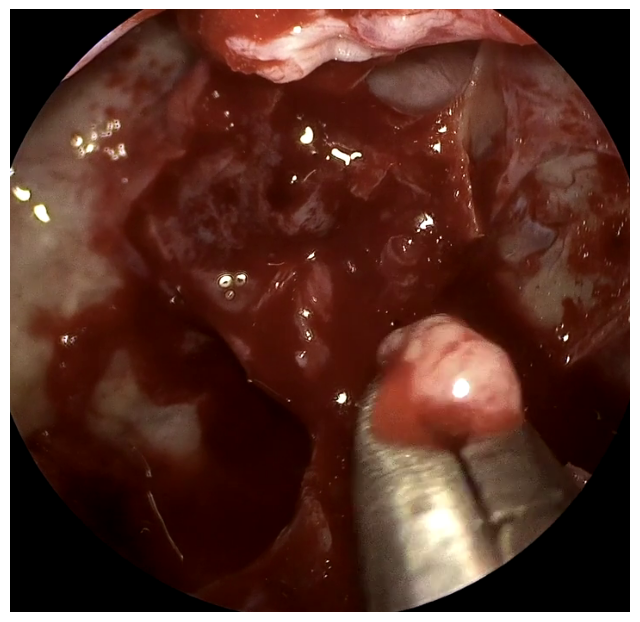

true labels: tensor([16,  8, 52, 33])
pred labels: tensor([16,  8, 52, 21])
What is the surgical phase shown in the image?
true answer: sellar
pred answer: sellar
What is the surgical step shown in this frame?
true answer: tumour_excision
pred answer: tumour_excision
What is the surgical operation performed in the image?
true answer: The tumour is seen and removed in a piecemeal fashion
pred answer: The tumour is seen and removed in a piecemeal fashion
What instrument is used at the centre of the image?
true answer: cup_forceps
pred answer: pituitary_rongeurs


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_everything(42)

# download image
!gdown 1qq2pVjZ-CZVVKP7gElERZVlgo9AjpmQq

# process image
transform = transforms.Compose([
       transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
       transforms.ToTensor(),
       ])
raw_image = Image.open('03828.png').convert('RGB')
image = transform(raw_image)
images = image.repeat(4, 1, 1, 1) # len(questions)=4
# print(images.shape) # torch.Size([4, 3, 224, 224])

# prepare questions and answers
questions = ['What is the surgical phase shown in the image?',
       'What is the surgical step shown in this frame?',
       'What is the surgical operation performed in the image?',
       'What instrument is used at the centre of the image?']
answers = ['sellar',
      'tumour_excision',
      'The tumour is seen and removed in a piecemeal fashion',
      'cup_forceps']

# define labels
labels = ['nasal_corridor_creation', 'anterior_sphenoidotomy', 'septum_displacement', 'sphenoid_sinus_clearance',
    'sellotomy', 'haemostasis', 'synthetic_graft_placement', 'durotomy', 'tumour_excision',
    'fat_graft_placement', 'gasket_seal_construct', 'dural_sealant', 'nasal_packing', 'debris_clearance',
    'end_of_step',
    'nasal_sphenoid', 'sellar', 'closure',  'end_of_phase',
    'suction', 'freer_elevator', 'pituitary_rongeurs', 'spatula_dissector', 'kerrisons', 'cottle',
    'haemostatic_foam', 'micro_doppler', 'nasal_cutting_forceps', 'stealth_pointer', 'irrigation_syringe',
    'retractable_knife', 'dural_scissors', 'ring_curette', 'cup_forceps', 'bipolar_forceps', 'tissue_glue',
    'surgical_drill',
    'zero', 'one', 'two',
    'top-left', 'top-right', 'centre', 'bottom-left', 'bottom-right',
    'The middle and superior turbinates are laterally displaced',
    'The sphenoid ostium is identified and opened', 'The septum is displaced until the opposite ostium is seen',
    'The sphenoid sinus is opened, with removal of sphenoid septations to expose the face of the sella and mucosa',
    'Haemostasis is achieved with a surgiflo, a bipolar cautery, and a spongostan placement',
    'The sella is identified, confirmed and carefully opened', 'A cruciate durotomy is performed',
    'The tumour is seen and removed in a piecemeal fashion', 'spongostan, tachosil and duragen placement',
    'A fat graft is placed over the defact', 'Evicel and Adherus dural sealant are applied',
    'Debris is cleared from the nasal cavity and choana', 'A MedPor implant and a fascia lata graft are placed',
    'The nasal cavity is packed with Bismuth soaked ribbon gauze']
labels_num = []
for i in range(len(answers)):
  labels_num.append(labels.index(answers[i]))
labels_num = torch.tensor(labels_num)

# plot image
plt.figure(figsize=(8, 8))
plt.imshow(raw_image)
plt.axis('off')
plt.show()

# preapre model
model_path = 'pitvqa_pit24_weights_3.pth.tar'
checkpoint = torch.load(model_path, map_location='cpu')
model = checkpoint['model']
model.to(device)

# inference
label_true = None
label_pred = None
model.eval()
with torch.no_grad():
    labels_num = labels_num.to(device)
    outputs = model(image=images.to(device), question=questions)

    scores, predicted = torch.max(F.softmax(outputs, dim=1).data, 1)
    if label_true is None:
        label_true = labels_num.data.cpu()
    else:
        label_true = torch.cat((label_true, labels_num.data.cpu()), 0)
    if label_pred is None:
        label_pred = predicted.data.cpu()
    else:
        label_pred = torch.cat((label_pred, predicted.data.cpu()), 0)
    print(f'true labels: {label_true}')
    print(f'pred labels: {label_pred}')

print('What is the surgical phase shown in the image?')
print(f'true answer: {labels[label_true[0]]}')
print(f'pred answer: {labels[label_pred[0]]}')
print('What is the surgical step shown in this frame?')
print(f'true answer: {labels[label_true[1]]}')
print(f'pred answer: {labels[label_pred[1]]}')
print('What is the surgical operation performed in the image?')
print(f'true answer: {labels[label_true[2]]}')
print(f'pred answer: {labels[label_pred[2]]}')
print('What instrument is used at the centre of the image?')
print(f'true answer: {labels[label_true[3]]}')
print(f'pred answer: {labels[label_pred[3]]}')